In this noteboook, I read in the Kaggle dataset.  Our goal is to have regressions to create scores for our players at each of the following features:

* Ace percentage (server and returner)
* 1st serve percentage (server and returner(?))
    * Not clear that returner's quality affects the pct of 1st serves in
* 1st serve point quality (server and returner)
* 2nd serve percentage (server and returner(?))
    * Not clear that returner's quality affects pct of 1st serves in
* 2nd serve point quality (server and returner)


#### TODO:
* Make this logistic regression instead of linear regression
* Tune weight
* Tune surface weights

In [1]:
from fetch.kaggle import parse_atp_data

df = parse_atp_data()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (9,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [2]:
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['tourney_date'] < MIN_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = df[
    (df['tourney_date'] > MIN_TEST_DATE) &
    (df['tourney_date'] < MAX_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [3]:
import pandas as pd

# Get player map
part1 = df[['winner_id', 'winner_name']].drop_duplicates('winner_id')
part2 = df[['loser_id', 'loser_name']].drop_duplicates('loser_id')
part1.rename(columns={'winner_id': 'player_id', 'winner_name': 'player_name'}, inplace=True)
part2.rename(columns={'loser_id': 'player_id', 'loser_name': 'player_name'}, inplace=True)
player_map_df = pd.concat([part1, part2])
player_map_df.drop_duplicates('player_id', inplace=True)

In [4]:
def sipko_weights(cur_date, train_df, disc, date_col='date', flat_time=1.):
    # Needs to be sorted prior to using
    # These are the time decay weights used in the paper.
    # min(disc ^ (# years elapsed), disc ^ (flat_time))
    max_weight = disc ** flat_time
    days_ago = (pd.to_datetime(cur_date) - train_df[date_col]).map(lambda x: x.days)
    years_ago = days_ago / 365.
    weights = disc ** years_ago
    return weights.clip(upper=max_weight)


_s_weights = sipko_weights(
    train_df['tourney_date'].max(),
    train_df,
    0.8,
    date_col='tourney_date',
    flat_time=1.
)

In [5]:
def characterize_solution(coef, inverse_player_mapping):
    coef_df = pd.DataFrame(
        list(enumerate(coef)),
        columns=['_mapped_id', 'coef']
    )
    coef_df['player_id'] = coef_df['_mapped_id'].map(lambda x: inverse_player_mapping[x])
    coef_df['side'] = coef_df['player_id'].map(lambda x: 'server' if x > 0 else 'returner')
    coef_df['player_id'] = coef_df['player_id'].abs()
    coef_df = pd.merge(
        coef_df,
        player_map_df,
        on='player_id'
    )
    return coef_df

In [6]:
from fetch.regression_features import get_X_y
from sklearn.linear_model import Ridge 
from fetch.regression_features import get_player_mapping

def do_model_for_feat(feat, train_df, alpha=100., two_sided=True):
    if two_sided:
        pm_df = df[
            df['p1_%s' % feat].notnull() &
            df['p2_%s' % feat].notnull()
        ]
    else:
        pm_df = df[
            df[feat].notnull()
        ]
    pm, ipm = get_player_mapping(pm_df, two_sided=two_sided)

    train_X, train_y, pm, ipm, weights = get_X_y(
        train_df,
        feat,
        player_mapping=pm,
        inv_player_mapping=ipm,
        weights=_s_weights,
        two_sided=two_sided
    )
    lin = Ridge(fit_intercept=True, alpha=alpha)
    lin.fit(train_X, train_y, sample_weight=weights)
    out = characterize_solution(lin.coef_, ipm)
    if two_sided:
        print out[out['side'] == 'server'].sort_values(by='coef', ascending=False).head(10)
        print out[out['side'] == 'returner'].sort_values(by='coef', ascending=True).head(10)
    else:
        print out.sort_values(by='coef', ascending=False).head(10)
    return out

first_won = do_model_for_feat('1stWon_pct', train_df)

      _mapped_id      coef  player_id    side         player_name
483         3794  0.061409     105683  server        Milos Raonic
2595        2646  0.057951     103333  server        Ivo Karlovic
3962        2975  0.055793     103819  server       Roger Federer
1275        3365  0.047243     104607  server       Tomas Berdych
1323        3339  0.042998     104542  server  Jo Wilfried Tsonga
957         3536  0.042078     105023  server         Sam Querrey
4010        3115  0.041829     104053  server        Andy Roddick
1321        3340  0.040103     104545  server          John Isner
1029        3494  0.029972     104925  server      Novak Djokovic
801         3623  0.029737     105227  server         Marin Cilic
      _mapped_id      coef  player_id      side         player_name
1028         524 -0.054730     104925  returner      Novak Djokovic
1032         526 -0.047067     104918  returner         Andy Murray
3963        3955 -0.040880     103819  returner       Roger Federer
11

In [7]:
second_won = do_model_for_feat('2ndWon_pct', train_df)

      _mapped_id      coef  player_id    side            player_name
3962        2975  0.047597     103819  server          Roger Federer
1029        3494  0.047449     104925  server         Novak Djokovic
1163        3428  0.044120     104745  server           Rafael Nadal
1321        3340  0.031479     104545  server             John Isner
4010        3115  0.029734     104053  server           Andy Roddick
483         3794  0.028676     105683  server           Milos Raonic
1521        3231  0.027431     104269  server      Fernando Verdasco
1159        3430  0.025463     104755  server        Richard Gasquet
805         3621  0.024455     105223  server  Juan Martin Del Potro
1815        3065  0.023632     103970  server           David Ferrer
      _mapped_id      coef  player_id      side            player_name
1028         524 -0.066945     104925  returner         Novak Djokovic
1032         526 -0.057036     104918  returner            Andy Murray
1814         937 -0.048807  

#### Investigate some of these features... 

In [8]:
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['tourney_date'] < MIN_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = df[
    (df['tourney_date'] > MIN_TEST_DATE) &
    (df['tourney_date'] < MAX_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [9]:
rel_players = test_df.sort_values(
    by='tourney_date', ascending=True
).drop_duplicates('winner_id', keep='last')
rel_players = rel_players[
    (rel_players['winner_rank'] < 30) &
    (rel_players['tourney_date'] > '2015-01-01')
]
rel_players = sorted(rel_players['winner_name'].unique())
rel_players

['Albert Ramos',
 'Alexander Zverev',
 'Andy Murray',
 'Bernard Tomic',
 'David Ferrer',
 'David Goffin',
 'Dominic Thiem',
 'Gael Monfils',
 'Gilles Simon',
 'Grigor Dimitrov',
 'Ivo Karlovic',
 'Jack Sock',
 'Jo Wilfried Tsonga',
 'John Isner',
 'Kei Nishikori',
 'Lucas Pouille',
 'Marin Cilic',
 'Milos Raonic',
 'Nick Kyrgios',
 'Novak Djokovic',
 'Pablo Cuevas',
 'Rafael Nadal',
 'Richard Gasquet',
 'Roberto Bautista Agut',
 'Roger Federer',
 'Stanislas Wawrinka',
 'Tomas Berdych',
 'Viktor Troicki']

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

def compare_two(f1, f2, side='server'):
    f1_df = do_model_for_feat(f1, train_df)
    f2_df = do_model_for_feat(f2, train_df)
    f1_df.rename(columns={'coef': '%s_coef' % f1}, inplace=True)
    together = pd.merge(
        f1_df,
        f2_df[['player_id', 'side', 'coef']],
        on=['player_id', 'side']
    )
    together.rename(columns={'coef': '%s_coef' % f2}, inplace=True)

    rel = together[together['side'] == side]
    plot_rel = rel[rel['player_name'].isin(rel_players)]
    fig, ax = plt.subplots()
    ax.scatter(plot_rel['%s_coef' % f1], plot_rel['%s_coef' % f2])
    for i, txt in enumerate(plot_rel['player_name'].tolist()):
        ax.annotate(
            txt,
            (plot_rel['%s_coef' % f1].iloc[i], plot_rel['%s_coef' % f2].iloc[i])
        )
    ax.set_xlabel('Normalized %s' % f1)
    ax.set_ylabel('Normalized %s' % f2)

      _mapped_id      coef  player_id    side        player_name
1321        3340  0.047984     104545  server         John Isner
1163        3428  0.044690     104745  server       Rafael Nadal
3954        2956  0.039574     103786  server  Nikolay Davydenko
170           85  0.034357     103813  server    Jarkko Nieminen
1029        3494  0.034035     104925  server     Novak Djokovic
4010        3115  0.033856     104053  server       Andy Roddick
1967        2972  0.033238     103812  server     Victor Hanescu
1631        3171  0.032806     104166  server  Alex Bogomolov Jr
1521        3231  0.032297     104269  server  Fernando Verdasco
2595        2646  0.032286     103333  server       Ivo Karlovic
      _mapped_id      coef  player_id      side        player_name
156           78 -0.012913     103720  returner     Lleyton Hewitt
658          333 -0.012378     105453  returner      Kei Nishikori
1358         693 -0.009500     104500  returner   Somdev Devvarman
1286         654 

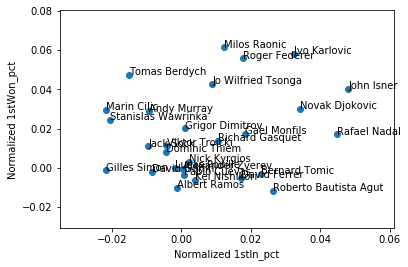

In [11]:
compare_two('1stIn_pct', '1stWon_pct')

      _mapped_id      coef  player_id    side        player_name
1321        3340  0.047982     104545  server         John Isner
1163        3428  0.044693     104745  server       Rafael Nadal
3954        2956  0.039574     103786  server  Nikolay Davydenko
170           85  0.034358     103813  server    Jarkko Nieminen
1029        3494  0.034037     104925  server     Novak Djokovic
4010        3115  0.033857     104053  server       Andy Roddick
1967        2972  0.033238     103812  server     Victor Hanescu
1631        3171  0.032809     104166  server  Alex Bogomolov Jr
1521        3231  0.032297     104269  server  Fernando Verdasco
2595        2646  0.032287     103333  server       Ivo Karlovic
      _mapped_id      coef  player_id      side        player_name
156           78 -0.012912     103720  returner     Lleyton Hewitt
658          333 -0.012378     105453  returner      Kei Nishikori
1358         693 -0.009498     104500  returner   Somdev Devvarman
1286         654 

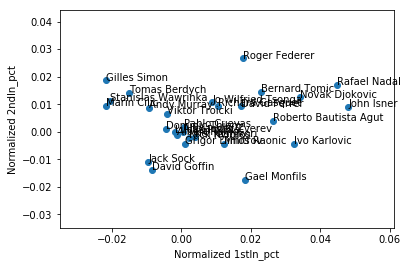

In [12]:
compare_two('1stIn_pct', '2ndIn_pct')

      _mapped_id      coef  player_id    side         player_name
483         3794  0.061411     105683  server        Milos Raonic
2595        2646  0.057952     103333  server        Ivo Karlovic
3962        2975  0.055797     103819  server       Roger Federer
1275        3365  0.047243     104607  server       Tomas Berdych
1323        3339  0.042997     104542  server  Jo Wilfried Tsonga
957         3536  0.042078     105023  server         Sam Querrey
4010        3115  0.041828     104053  server        Andy Roddick
1321        3340  0.040109     104545  server          John Isner
1029        3494  0.029975     104925  server      Novak Djokovic
801         3623  0.029740     105227  server         Marin Cilic
      _mapped_id      coef  player_id      side         player_name
1028         524 -0.054729     104925  returner      Novak Djokovic
1032         526 -0.047070     104918  returner         Andy Murray
3963        3955 -0.040878     103819  returner       Roger Federer
11

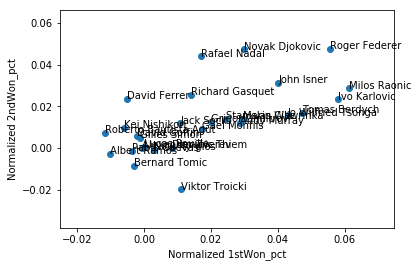

In [13]:
compare_two('1stWon_pct', '2ndWon_pct')

      _mapped_id      coef  player_id    side         player_name
483         3794  0.061411     105683  server        Milos Raonic
2595        2646  0.057951     103333  server        Ivo Karlovic
3962        2975  0.055795     103819  server       Roger Federer
1275        3365  0.047243     104607  server       Tomas Berdych
1323        3339  0.042999     104542  server  Jo Wilfried Tsonga
957         3536  0.042078     105023  server         Sam Querrey
4010        3115  0.041827     104053  server        Andy Roddick
1321        3340  0.040108     104545  server          John Isner
1029        3494  0.029976     104925  server      Novak Djokovic
801         3623  0.029740     105227  server         Marin Cilic
      _mapped_id      coef  player_id      side         player_name
1028         524 -0.054726     104925  returner      Novak Djokovic
1032         526 -0.047069     104918  returner         Andy Murray
3963        3955 -0.040878     103819  returner       Roger Federer
11

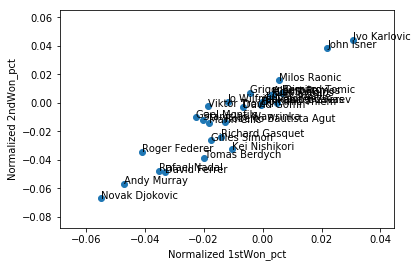

In [14]:
# Should expect these to be very highly correlated
compare_two('1stWon_pct', '2ndWon_pct', side='returner')

#### Try "One-Sided Feature" like Winning...

Using an "ELO" model as a feature here might produce a much better model! 

In [15]:
elo_rankings = do_model_for_feat(
    'y',
    train_df,
    two_sided=False
)

      _mapped_id      coef  player_id    side            player_name
2774        2774  0.307087     104925  server         Novak Djokovic
2307        2307  0.287729     103819  server          Roger Federer
2770        2770  0.234150     104918  server            Andy Murray
2707        2707  0.233093     104745  server           Rafael Nadal
2893        2893  0.182436     105223  server  Juan Martin Del Potro
2645        2645  0.160953     104607  server          Tomas Berdych
2418        2418  0.155768     104053  server           Andy Roddick
2616        2616  0.153651     104542  server     Jo Wilfried Tsonga
2374        2374  0.151377     103970  server           David Ferrer
3039        3039  0.144818     105683  server           Milos Raonic


Looks reasonable...What if we use a logistic regression?  How good would that model be on its own?

In [16]:
from sklearn.linear_model import LogisticRegression

pm_df = df[
    df['y'].notnull()
]
pm, ipm = get_player_mapping(pm_df, two_sided=False)

train_X, train_y, pm, ipm, weights = get_X_y(
    train_df,
    'y',
    player_mapping=pm,
    inv_player_mapping=ipm,
    weights=_s_weights,
    two_sided=False
)
test_X, test_y, _, _, _ = get_X_y(
    test_df,
    'y',
    player_mapping=pm,
    inv_player_mapping = ipm,
    weights=None,
    two_sided=False
)

lr = LogisticRegression(C=0.4, fit_intercept=False)
lr.fit(train_X, train_y.astype(int), sample_weight=weights)
out = characterize_solution(lr.coef_[0], ipm)
out.sort_values(by='coef', ascending=False).head(10)

,_mapped_id,coef,player_id,side,player_name
2774,2774,2.795374,104925,server,Novak Djokovic
2307,2307,2.617673,103819,server,Roger Federer
2707,2707,2.305388,104745,server,Rafael Nadal
2770,2770,2.198837,104918,server,Andy Murray
2893,2893,1.876230,105223,server,Juan Martin Del Potro
2418,2418,1.663851,104053,server,Andy Roddick
2616,2616,1.586897,104542,server,Jo Wilfried Tsonga
2645,2645,1.545384,104607,server,Tomas Berdych
2374,2374,1.530548,103970,server,David Ferrer
3039,3039,1.524851,105683,server,Milos Raonic


In [17]:
from sklearn.metrics import roc_auc_score

preds = lr.predict_proba(test_X)[:, 1]
roc_auc_score(test_y.astype(int), preds)

0.7243485910624412

AUC of 0.725 without any updates!

#### Tune models / weighting

TODO:
* Should regularization differ with sample size?
* Should we train on all surfaces?
* Tune regularization parameter for these models? * Change to binary outcome (weight by # of each outcome)?

#### Backfill over time
Let's backfill these features over time...

In [18]:
MIN_TRAIN_DATE = '1990-01-01'
MIN_TEST_DATE = '2000-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['tourney_date'] < MIN_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = df[
    (df['tourney_date'] > MIN_TEST_DATE) &
    (df['tourney_date'] < MAX_TEST_DATE) &
    (df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [26]:
import itertools
from fetch.regression_features import get_X_y
from sklearn.linear_model import Ridge 
from fetch.regression_features import get_player_mapping

FEATS = [
    'svWon_pct',
    '1stIn_pct',
    '1stWon_pct',
    '2ndIn_pct',
    '2ndWon_pct',
    'ace_pct',
    'y'
]


def update_for_feat(feat, train_df, test_df, two_sided=True):
    # TODO: Add test_df here too...
    if two_sided:
        pm_df = df[
            df['p1_%s' % feat].notnull() &
            df['p2_%s' % feat].notnull()
        ]
    else:
        pm_df = df[df[feat].notnull()]
    pm, ipm = get_player_mapping(pm_df, two_sided=two_sided)

    _s_weights = sipko_weights(
        train_df['tourney_date'].max(),
        train_df,
        0.8,
        date_col='tourney_date',
        flat_time=1.
    )

    train_X, train_y, pm, ipm, weights = get_X_y(
        train_df,
        feat,
        player_mapping=pm,
        inv_player_mapping=ipm,
        weights=_s_weights,
        two_sided=two_sided
    )

    if two_sided:
        lin = Ridge(fit_intercept=True, alpha=100.)
        lin.fit(train_X, train_y, sample_weight=weights)
    else:
        lin = LogisticRegression(fit_intercept=False, C=0.4)
        lin.fit(train_X, train_y, sample_weight=weights)
        
    coef_df = pd.DataFrame(
        [(ipm[k], v) for k, v in list(enumerate(lin.coef_.reshape(-1)))],
        columns=['player_id', '%s_coef' % feat]
    )    

    test_df = pd.merge(
        test_df,
        coef_df,
        left_on='p1_id',
        right_on='player_id'
    )
    test_df.rename(
        columns={'%s_coef' % feat: 'p1_%s_server' % feat},
        inplace=True
    )
    test_df.drop('player_id', axis=1, inplace=True)
    test_df = pd.merge(
        test_df,
        coef_df,
        left_on='p2_id',
        right_on='player_id'
    )
    test_df.rename(
        columns={'%s_coef' % feat: 'p2_%s_server' % feat},
        inplace=True
    )
    test_df.drop('player_id', axis=1, inplace=True)

    if two_sided:
        coef_df['player_id'] = -coef_df['player_id']
        test_df = pd.merge(
            test_df,
            coef_df,
            left_on='p1_id',
            right_on='player_id'
        )
        test_df.rename(
            columns={'%s_coef' % feat: 'p1_%s_returner' % feat},
            inplace=True
        )
        test_df.drop('player_id', axis=1, inplace=True)

        test_df = pd.merge(
            test_df,
            coef_df,
            left_on='p2_id',
            right_on='player_id'
        )
        test_df.rename(
            columns={'%s_coef' % feat: 'p2_%s_returner' % feat},
            inplace=True
        )
        test_df.drop('player_id', axis=1, inplace=True)
    return test_df 
    
def backfill(update_period=50):
    # Should backfill features
    out = []
    cur_date = test_df['tourney_date'].min()
    while(cur_date < pd.to_datetime(MAX_TEST_DATE)):
        print cur_date
        cur_train_df = df[
            (df['tourney_date'] >= MIN_TRAIN_DATE) &
            (df['tourney_date'] < cur_date)
        ].copy()
        cur_test_df = df[
            (df['tourney_date'] >= cur_date) &
            (df['tourney_date'] < cur_date + pd.Timedelta(days=update_period)) &
            (df['tourney_date'] < MAX_TEST_DATE) &
            (df['surface'] == 'Hard')
        ].copy()
        if cur_test_df.shape[0] > 0:
            for feat in FEATS:
                cur_test_df = update_for_feat(feat, cur_train_df, cur_test_df, two_sided=(feat!='y'))
            out_feats = list(itertools.chain(*[[
                'p1_%s_server' % feat,
                'p1_%s_returner' % feat,
                'p2_%s_server' % feat,
                'p2_%s_returner' % feat
            ] for feat in FEATS if feat != 'y']))
            out_feats.extend([
                'p1_y_server',
                'p2_y_server'
            ])
            out.append(cur_test_df[
                out_feats + ['tourney_date', 'match_id', 'y', 'surface']
            ])
        cur_date = cur_date + pd.Timedelta(days=update_period)
    return pd.concat(out)

In [27]:
w = update_for_feat('y', train_df, test_df, two_sided=False)

In [28]:
backfilled_feats = backfill()

2000-01-03 00:00:00
2000-02-22 00:00:00
2000-04-12 00:00:00
2000-06-01 00:00:00
2000-07-21 00:00:00
2000-09-09 00:00:00
2000-10-29 00:00:00
2000-12-18 00:00:00
2001-02-06 00:00:00
2001-03-28 00:00:00
2001-05-17 00:00:00
2001-07-06 00:00:00
2001-08-25 00:00:00
2001-10-14 00:00:00
2001-12-03 00:00:00
2002-01-22 00:00:00
2002-03-13 00:00:00
2002-05-02 00:00:00
2002-06-21 00:00:00
2002-08-10 00:00:00
2002-09-29 00:00:00
2002-11-18 00:00:00
2003-01-07 00:00:00
2003-02-26 00:00:00
2003-04-17 00:00:00
2003-06-06 00:00:00
2003-07-26 00:00:00
2003-09-14 00:00:00
2003-11-03 00:00:00
2003-12-23 00:00:00
2004-02-11 00:00:00
2004-04-01 00:00:00
2004-05-21 00:00:00
2004-07-10 00:00:00
2004-08-29 00:00:00
2004-10-18 00:00:00
2004-12-07 00:00:00
2005-01-26 00:00:00
2005-03-17 00:00:00
2005-05-06 00:00:00
2005-06-25 00:00:00
2005-08-14 00:00:00
2005-10-03 00:00:00
2005-11-22 00:00:00
2006-01-11 00:00:00
2006-03-02 00:00:00
2006-04-21 00:00:00
2006-06-10 00:00:00
2006-07-30 00:00:00
2006-09-18 00:00:00


##### Train model on backfilled features
First, without ELO as a feature

In [70]:
MIN_TRAIN_DATE = '1990-01-01'
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = backfilled_feats[
    (backfilled_feats['tourney_date'] < MIN_TEST_DATE) &
    (backfilled_feats['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = backfilled_feats[
    (backfilled_feats['tourney_date'] > MIN_TEST_DATE) &
    (backfilled_feats['tourney_date'] < MAX_TEST_DATE) &
    (backfilled_feats['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [71]:
TRAIN_FEATS = list(itertools.chain(*[[
    'p1_%s_server' % feat,
    'p1_%s_returner' % feat,
    'p2_%s_server' % feat,
    'p2_%s_returner' % feat
] for feat in FEATS if feat != 'y']))

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=10)
rf.fit(train_df[TRAIN_FEATS], train_df['y'])
preds = rf.predict_proba(test_df[TRAIN_FEATS])[:, 1]
roc_auc_score(test_df['y'], preds)

0.74298233641973088

Pretty good performance!  Would be even better if we added features for player overall quality and fatigue and such!

#### Now with ELO

In [35]:
# Compare to just ELO
import numpy as np

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

elo_preds = sigmoid(test_df['p1_y_server'] - test_df['p2_y_server'])
roc_auc_score(test_df['y'], elo_preds)

0.74725708087606757

Just ELO preds do almost as well!  Let's see if I can make a better model through the features...

In [45]:
TWO_WAY_FEATS = list(itertools.chain(*[[
    'p1_%s_server' % feat,
    'p1_%s_returner' % feat,
    'p2_%s_server' % feat,
    'p2_%s_returner' % feat
] for feat in FEATS if feat != 'y']))

train_df['elo_pred'] = sigmoid(train_df['p1_y_server'] - train_df['p2_y_server'])
test_df['elo_pred'] = sigmoid(test_df['p1_y_server'] - test_df['p2_y_server'])

train_feats = TWO_WAY_FEATS + ['elo_pred']

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=10)
rf.fit(train_df[train_feats], train_df['y'])
preds = rf.predict_proba(test_df[train_feats])[:, 1]
roc_auc_score(test_df['y'], preds)

0.75242488129700535

Got half a point from including other features!

In [68]:
N_ATTEMPTS = 30

min_samples_leaf_tune = (10 ** np.random.uniform(low=1, high=3, size=N_ATTEMPTS)).astype(int)
max_features_tune = (np.random.uniform(low=1. / len(train_feats), high=1, size=N_ATTEMPTS) * len(train_feats)).astype(int)

out = []
for msl, mf in zip(min_samples_leaf_tune, max_features_tune):
    print msl, mf
    rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=msl, max_features=mf)
    rf.fit(train_df[train_feats], train_df['y'])
    preds = rf.predict_proba(test_df[train_feats])[:, 1]
    auc = roc_auc_score(test_df['y'], preds)
    print auc
    out.append((msl, mf,auc))

510 5
0.745378484768
221 18
0.753827767522
591 10
0.748611659831
10 1
0.75127071466
34 11
0.754362918693
15 11
0.75258183503
21 12
0.754370820254
65 4
0.752517904219
33 10
0.755220956376
44 16
0.755520317786
615 10
0.748137207014
314 0


ValueError: max_features must be in (0, n_features]

In [69]:
tune_df = pd.DataFrame(
    out,
    columns=['msl', 'mf', 'auc']
)
tune_df.sort('auc', ascending=False)

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """


,msl,mf,auc
9,44,16,0.755520
8,33,10,0.755221
6,21,12,0.754371
4,34,11,0.754363
1,221,18,0.753828
5,15,11,0.752582
7,65,4,0.752518
3,10,1,0.751271
2,591,10,0.748612
10,615,10,0.748137


##### Stack instead of model jointly?

In [74]:
# Server / returner feats
rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=10)
rf.fit(train_df[TWO_WAY_FEATS], train_df['y'])
preds = rf.predict_proba(test_df[TWO_WAY_FEATS])[:, 1]
roc_auc_score(test_df['y'], preds)

0.74186857549223117

In [76]:
# Just ELO
test_df['elo_pred'] = sigmoid(test_df['p1_y_server'] - test_df['p2_y_server'])
roc_auc_score(test_df['y'], test_df['elo_pred'])

0.74725708087606757

In [86]:
# 50% stack
out = []
for alpha in np.linspace(0, 1, 101):
    new_preds = alpha * preds + (1. - alpha) * test_df['elo_pred']
    auc = roc_auc_score(test_df['y'], new_preds)
    out.append((alpha, auc))

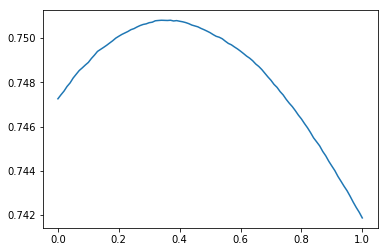

In [87]:
plt.plot(zip(*out)[0], zip(*out)[1])

In [88]:
stack_df = pd.DataFrame(
    out,
    columns=['alpha', 'auc']
)
stack_df.sort('auc', ascending=False).head()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """


,alpha,auc
37,0.37,0.750810
34,0.34,0.750809
35,0.35,0.750804
36,0.36,0.750799
33,0.33,0.750798


Still not as good as combined model

##### More feature engineering to make symmetric

Above, our features are not being used in a symmetric way...in other words, the prediction depends on who is p1 and who is p2!

In [48]:
engineered_df = backfilled_feats.copy()

In [54]:
p1_feats = [x for x in TWO_WAY_FEATS if 'p1' in x]
new_feats = []
# First, straight up advantages
for feat in p1_feats:
    p2_feat = feat.replace('p1', 'p2')
    new_feat_name = feat.replace('_server', '_serve_diff')
    new_feat_name = new_feat_name.replace('_returner', '_return_diff')
    new_feat_name = new_feat_name.replace('p1_', '')
    engineered_df[new_feat_name] = engineered_df[feat] - engineered_df[p2_feat]
    new_feats.append(new_feat_name)
    
p1_serve_feats = [feat for feat in p1_feats if '_server' in feat]
for p1_serve in p1_serve_feats:
    p1_return = p1_serve.replace('_server', '_returner')
    p2_serve = p1_serve.replace('p1', 'p2')
    p2_return = p2_serve.replace('_server', '_returner')
    
    new_feat_name = p1_serve.replace('p1_', '').replace('_server', '_serve_advantage')
    engineered_df[new_feat_name] = (
        (engineered_df[p1_serve] + engineered_df[p2_return]) -
        (engineered_df[p2_serve] + engineered_df[p1_return])
    )
    new_feats.append(new_feat_name)
    
engineered_df['elo_pred'] = sigmoid(engineered_df['p1_y_server'] - engineered_df['p2_y_server'])
new_feats += ['elo_pred']

In [55]:
engineered_df[[
    '1stIn_pct_serve_diff',
    '1stIn_pct_return_diff',
    '1stIn_pct_serve_advantage'
]].head()

,1stIn_pct_serve_diff,1stIn_pct_return_diff,1stIn_pct_serve_advantage
0,-0.010884,-0.007371,-0.003513
1,0.030942,0.004643,0.026300
2,-0.015452,-0.010320,-0.005132
3,-0.017709,0.006981,-0.024690
4,-0.026412,-0.003355,-0.023057


In [56]:
MIN_TRAIN_DATE = '1990-01-01'
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = engineered_df[
    (engineered_df['tourney_date'] < MIN_TEST_DATE) &
    (engineered_df['surface'] == 'Hard')  # TODO: Surface weights
].copy()
test_df = engineered_df[
    (engineered_df['tourney_date'] > MIN_TEST_DATE) &
    (engineered_df['tourney_date'] < MAX_TEST_DATE) &
    (engineered_df['surface'] == 'Hard')  # TODO: Surface Weights
].copy()

In [89]:
test_df.shape

(3339, 31)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_features=10)
rf.fit(train_df[new_feats], train_df['y'])
preds = rf.predict_proba(test_df[new_feats])[:, 1]
roc_auc_score(test_df['y'], preds)

0.74132354736985762

In [58]:
imp_df = pd.DataFrame(
    zip(new_feats, rf.feature_importances_),
    columns=['feature', 'imp']
)
imp_df.sort('imp', ascending=False)

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """


,feature,imp
18,elo_pred,0.251185
12,svWon_pct_serve_advantage,0.113677
14,1stWon_pct_serve_advantage,0.058148
8,2ndWon_pct_serve_diff,0.042756
7,2ndIn_pct_return_diff,0.042740
3,1stIn_pct_return_diff,0.041112
0,svWon_pct_serve_diff,0.041015
16,2ndWon_pct_serve_advantage,0.038954
11,ace_pct_return_diff,0.037271
6,2ndIn_pct_serve_diff,0.035397


#### Make symmetric by including each data point twice? 

TODO:
    * Add feature for winning the match...likely very important
    * Backfill more frequently (requires sorting by tourney date and round / match_num)
    * Make features subtractions of each other
        * Straight differences don't seem to work too well...
        * Include each match twice, one each way...this way has to be symmetric
        * Include all symmetric differences and regularize model like cray?
    * Add features about clutchness / break points?
    * Tune RF, recency weights, etc.
    * See if same regularization over time makes signals larger over time...
    * Include head to head where it exists...
    * ANN vs. RF?